# Package and functions

In [1]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.octave import *
from qm.qua import *


#General os library 
import os
import time as time_package
import sys


import matplotlib.pyplot as plt
from qualang_tools.units import unit
from set_octave import get_L0_and_IF
from configuration_multiple_jumps import *
from qm import SimulationConfig, LoopbackInterface
from qualang_tools.units import unit
from qualang_tools.loops import from_array
u = unit()
from qualang_tools.plot import interrupt_on_close
from qualang_tools.results import progress_counter, fetching_tool
from qualang_tools.addons.variables import assign_variables_to_element



#Path for HQCPC7 
sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Analysis_Function\NonLinearRes')
sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Drivers\Drivers') #path for the analysis function

#Path for HQC PC15 
# sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu\Analysis_Function\NonLinearRes')
# sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu\Drivers')
import AnFunc as an # analysis function
import imageio
import scipy.io
from scipy import signal
from scipy.optimize import curve_fit

In [2]:
def update_two_photon_lenght(twoPhoton_len,config,qmm):
    """ Update the length of the fluxline pulse in the configuration file"""

    config["pulses"]["twoPhoton"]["length"]=twoPhoton_len


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm


def update_readout_lenght(Readout_Len,config,qmm):
    """ Macro to update the readout length in the configuration file"""
    
    config["pulses"]["zero_pulse"]["length"]=Readout_Len
    config["integration_weights"]["cosine_weights"]["cosine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["cosine_weights"]["sine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["sine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["sine"][0]=(-1.0, Readout_Len)


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm


def update_pulse_amplitude(pulse_amp,config,qmm):
    config["waveforms"]["const_wf"]['sample']=pulse_amp
    
    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm

def update_offset(offset_1, offset_2,config,qmm):
    """ Update the input offsets of the qm in the configuration file """
    
    config['controllers']["con1"]["analog_inputs"][1]['offset']=offset_1
    config['controllers']["con1"]["analog_inputs"][2]['offset']=offset_2
    
    
    qm=qmm.open_qm(config)
    
    return config, qm

def update_time_of_flight(time_of_flight,config,qmm):
    """ Update the time_of_flight of the qm in the configuration file """
    config["elements"]["resonator"]["time_of_flight"]=time_of_flight
    
    qm=qmm.open_qm(config)
    
    return config, qm



def plot_init_av_single(I,Q,time,n_avg,bin_size,n_angle,figsize,fontsize,dpi):

    fig, axs = plt.subplots( nrows=3, ncols=2, figsize=figsize,dpi=dpi)

    #Plot without reducing 
    ax=axs[0,0]
    ax.plot(I,Q,".",markersize=2)
    ax.set_title('Pump Frequency '+str(IF_pump)+" Amplitude"+str(amp_factor),fontsize=fontsize)
    ax.set_xlabel("I [$V$]",fontsize=fontsize)
    ax.set_ylabel("Q [$V$]",fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.axis("equal")

    ax=axs[1,0]
    ax.plot(time,I, ".", markersize=2)
    ax.set_xlabel("Time [s]",fontsize=fontsize)
    ax.set_ylabel("I",fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)

    ax=axs[2,0]
    ax.hist2d(I,Q,bins=bin_size)
    ax.set_xlabel("I [$V$]",fontsize=fontsize)
    ax.set_ylabel("Q [$V$]",fontsize=fontsize)
    ax.set_facecolor(color=(68/255,1/255,84/255))
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.axis("equal")

    #Plot with reducing 
    average_I, average_Q, time_average=rot_and_av_single(I,Q,time,n_angle,n_avg)

    ax=axs[0,1]
    ax.plot(average_I.transpose(),average_Q.transpose(),".",markersize=2)
    ax.set_title('Pump Frequency '+str(IF_pump)+" Amplitude"+str(amp_factor),fontsize=fontsize)
    ax.set_xlabel("I [$V$]",fontsize=fontsize)
    ax.set_ylabel("Q [$V$]",fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.axis("equal")


    ax=axs[1,1]
    ax.plot(time_average,average_I[0,:], ".", markersize=2)
    ax.set_xlabel("Time [s]",fontsize=fontsize)
    ax.set_ylabel("I",fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)


    ax=axs[2,1]
    ax.hist2d(average_I[0,:],average_Q[0,:],bins=bin_size)
    ax.set_xlabel("I [$V$]",fontsize=fontsize)
    ax.set_ylabel("Q [$V$]",fontsize=fontsize)
    ax.set_facecolor(color=(68/255,1/255,84/255))
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.axis("equal")

    print("Average signal : {}".format(np.mean(abs(I))))
    
    
def rot_and_av_single(I,Q,time,nb_angle,n_avg):
    
    #reshape the data to fit into the initial function
    I_2d=np.reshape(I, (1, I.shape[0])) 
    Q_2d=np.reshape(Q, (1, Q.shape[0]))
    rot_I,rot_Q=an.rotate_data(I_2d,Q_2d,nb_angle)
    average_I,average_Q,time_average=an.average_data(rot_I,rot_Q,time,n_avg)

    return average_I, average_Q, time_average




def single_IQ_trace(IF_pump,IF_resonator,Offset_IF,amp_factor,n_runs,Readout_Delay,points_delay,Readout_Len,qm):
    
    """ gets the IQ values for a given pump frequency and amplitude 
    IF_Pump : If frequency of the pump 
    IF_resonator : IF frequency of the resonator (should be calculated before such that it gives half of the pump total frequency (LO_fluxline+IF_pump)/2-LO_readout
    Offset_IF : in case the down converted frequency is not perfectly centered around 0. This is typically kept to zero
    amp_facot amplitude factor of the pump
    n_runs : number of points 
    Readout_delay : waiting time before the first readout in clock cycle
    Readout_Len : time in ns of each readout 
    points_delay: waiting time between collected points 
    qm : quantum manager 

    returns :

    I: vector n_runs components of the frist quadrature
    Q : vector of n_runs compontents of the second quadrature
    time : vector of the time """


    with program() as IQ_blobs:

        n = declare(int)
        i = declare(int)
        I = declare(fixed)
        Q = declare(fixed)
        assign_variables_to_element("resonator", I,Q) #This line forces the OPX to assign I and Q to the resonator element such that the loops can happen in parallel as intented
        I_st = declare_stream()
        Q_st = declare_stream()
        f = declare(int)
        
        it_numb_st=declare_stream()

        # Change the of the pump and resonator to demodulate better
        update_frequency("resonator",IF_resonator+Offset_IF) 
        update_frequency("fluxline",IF_pump)

        #Play a continuous loop sending a pulse through the fluxline 
        

        #Delay time before the first readout 
        wait(Readout_Delay,"resonator")
        
        with for_(i, 0, i < np.round((n_runs*(Readout_Len+300+points_delay*4)+Readout_Delay*4)/twoPhoton_len)+1, i + 1): # the 300 is added because there is a time delay associated to saving the data in the steam. The *4 is necessary because the waiting time is in clockcycle 
            play("pumping" * amp(amp_factor), 'fluxline')  # Play the pulse on the fluxline

        with for_(n, 0, n < n_runs, n + 1):

            #Demodulate for the length 
            measure(
                "fake_readout",
                "resonator",
                None,
                dual_demod.full("cos", "out1", "sin", "out2", I),
                dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
            )

            save(I, I_st)
            save(Q, Q_st)
            
            save(n,it_numb_st)

            wait(points_delay,"resonator")
        

        with stream_processing():
            I_st.with_timestamps().save_all("I")
            Q_st.with_timestamps().save_all("Q")
            it_numb_st.save("iteration")


    simulation = False
    if simulation:

        simulation_config = SimulationConfig(
            duration=80000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
        )
        job = qmm.simulate(config, IQ_blobs, simulation_config)
        job.get_simulated_samples().con1.plot(analog_ports={'1','2','3','4' },digital_ports={'1','3'})

    else: 



        job = qm.execute(IQ_blobs)
        results = fetching_tool(job, data_list=["I", "Q","iteration"], mode="live")

        fig = plt.figure()
        interrupt_on_close(fig, job)
        while results.is_processing():

            I, Q,iteration = results.fetch_all()

            time=I["timestamp"]
            I = u.demod2volts(I["value"], Readout_Len) #diviser par la duree du pulse 
            Q = u.demod2volts(Q["value"], Readout_Len)

            #plt.subplot(211)
            plt.subplot(211)
            plt.cla()
            fig.suptitle("IF_pump "+str(IF_pump) +" Progress :"+str(round(iteration/n_runs,2)))
            plt.plot(I[:min(len(I), len(Q))], Q[:min(len(I), len(Q))], ".", markersize=2)
            plt.xlabel("I")
            plt.ylabel("Q")
            plt.axis("equal")
            plt.subplot(212)
            plt.cla()
            tau=np.linspace(1,min(len(I), len(Q)),min(len(I), len(Q)))
            plt.plot(tau,np.angle(I[:min(len(I), len(Q))]+1j*Q[:min(len(I), len(Q))]), ".", markersize=2)
            plt.xlabel("nb_points")
            plt.ylabel("phase")
            plt.pause(0.1)

        I, Q, iteration = results.fetch_all()
        time=I["timestamp"]
        I = u.demod2volts(I["value"], Readout_Len) #diviser par la duree du pulse 
        Q = u.demod2volts(Q["value"], Readout_Len)

      
    return time, I, Q



# OPX configuration

In [3]:
#Octave & OPX configuration 
Saving_Path=r"\\sb1files\HQC\Users\beaulieu\Data\Run01\131\\"
Cooldown_Date="2023_05_05"


opx_ip = '128.178.175.167'
opx_port = 81
octave_ip = '128.178.175.167'
octave_port = 53


octave_config = QmOctaveConfig()
octave_config.set_calibration_db(os.getcwd()) #Path to the calibration database 

octave_config.add_device_info('octave1', octave_ip, octave_port) #Add a device refered to as octave 1
octave_config.set_opx_octave_mapping([('con1', 'octave1')])  # set default mapping between analog outputs of OPX and the octave

qmm = QuantumMachinesManager(host=opx_ip, port=opx_port, octave=octave_config)
qm = qmm.open_qm(config)

octave_output_gain=-10

#Mixers for the fluxline 
qmm.octave_manager.set_clock("octave1", ClockType.External, ClockFrequency.MHZ_10) # External clock on the octave 
qm.octave.set_lo_source("fluxline", OctaveLOSource.Internal) # Use internal LO for the fluxline 
qm.octave.set_lo_frequency("fluxline", LO_fluxline)  # Set the frequency of the LO 
qm.octave.set_rf_output_gain("fluxline", octave_output_gain)  # can set gain from -10dB to 20dB
qm.octave.set_rf_output_mode("fluxline", RFOutputMode.on)  # The LO output is always on (could change to a trigger)

#Mixers for the resonator 
qm.octave.set_qua_element_octave_rf_in_port("resonator", "octave1", 1) #input port 1 is set for the resonator 
qm.octave.set_downconversion("resonator", lo_source=RFInputLOSource.Internal)  # The LO for the demodulation is the interal LO  
qm.octave.set_lo_frequency("resonator", LO_readout)  # assign the LO inside the octave to element

2023-05-13 15:56:31,523 - qm - INFO - Performing health check
2023-05-13 15:56:31,537 - qm - WARNING -   HC Warning: Potential hardware issue with QSync in controller con1, multiple controllers sync cannot be guaranteed, please inform QM
2023-05-13 15:56:31,538 - qm - INFO - Health check passed


In [10]:
#Setting the gain
gain=0
config['controllers']['con1']['analog_inputs'][1]["gain_db"]=gain
config['controllers']['con1']['analog_inputs'][2]["gain_db"]=gain
qm = qmm.open_qm(config)

#Pump length 
twoPhoton_len=10_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

time_of_flight=24
config, qm=update_time_of_flight(time_of_flight,config,qmm)

pulse_amp=0.125
config,qm=update_pulse_amplitude(pulse_amp,config,qmm)

#Based on the other setting
offset_1=0.0180632734375
offset_2=0.015605841992187498
config,qm=update_offset(offset_1, offset_2,config,qmm)

# Display the parameters 

In [5]:
print("LO of resonator : {} GHz".format(config['elements']['resonator']["mixInputs"]["lo_frequency"]/1e9))
print("IF of resonator : {} GHz".format(config['elements']['resonator']['intermediate_frequency']/1e9))
print("Time of flight of resonator : {} ns".format(config['elements']['resonator']['time_of_flight']))
print("Readout time resonator : {} ns".format(config["pulses"]["zero_pulse"]["length"]))
print("LO of fluxline: {} GHz".format(config['elements']['fluxline']["mixInputs"]["lo_frequency"]/1e9))
print("IF of fluxline : {} GHz".format(config['elements']['fluxline']['intermediate_frequency']/1e9))
print("Fluxline pulse time : {} ns".format(config["pulses"]["twoPhoton"]["length"]))
print("Fluxline amplitude : {} V".format(config["waveforms"]["twoPhoton_wf"]['sample']))

LO of resonator : 4.3 GHz
IF of resonator : 0.318 GHz
Time of flight of resonator : 24 ns
Readout time resonator : 2000000 ns
LO of fluxline: 8.6 GHz
IF of fluxline : 0.0995 GHz
Fluxline pulse time : 1000 ns
Fluxline amplitude : 0.125 V


# Testing the Pump 

In [6]:
#Mixer Calibration 
#Calibration of the fluxline mixer for the pump 
qm.octave.calibrate_element("fluxline", [get_L0_and_IF(config, "fluxline")])  
qm = qmm.open_qm(config)

qm.octave.calibrate_element("resonator", [get_L0_and_IF(config, "resonator")])  
qm = qmm.open_qm(config)

2023-05-13 15:56:41,336 - qm - INFO - Flags: 
2023-05-13 15:56:41,336 - qm - INFO - Compiling program
2023-05-13 15:56:43,812 - qm - INFO - Sending pre-compiled program to QOP
2023-05-13 15:56:47,434 - qm - INFO - Flags: 
2023-05-13 15:56:47,435 - qm - INFO - Compiling program
2023-05-13 15:56:50,115 - qm - INFO - Sending pre-compiled program to QOP


In [ ]:
# Applies an infinite loop pump for testing 

amp_factor=0.1

pulse_amp=0.125/2
config,qm=update_pulse_amplitude(pulse_amp,config,qmm) 

twoPhoton_len=1000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

with program() as TwoPhoton:
    with infinite_loop_():
        play("pumping"*amp(amp_factor), 'fluxline')
           
job = qm.execute(TwoPhoton)

In [ ]:
#Two stop the two photon pumping 
job.halt()

# Checking the ADC 
This allows checking that the ADC is not saturated to set a proper gain, correct for DC offsets and define the time of flight.

For this, we send a Twophoton pulse and look at the the raw adc 

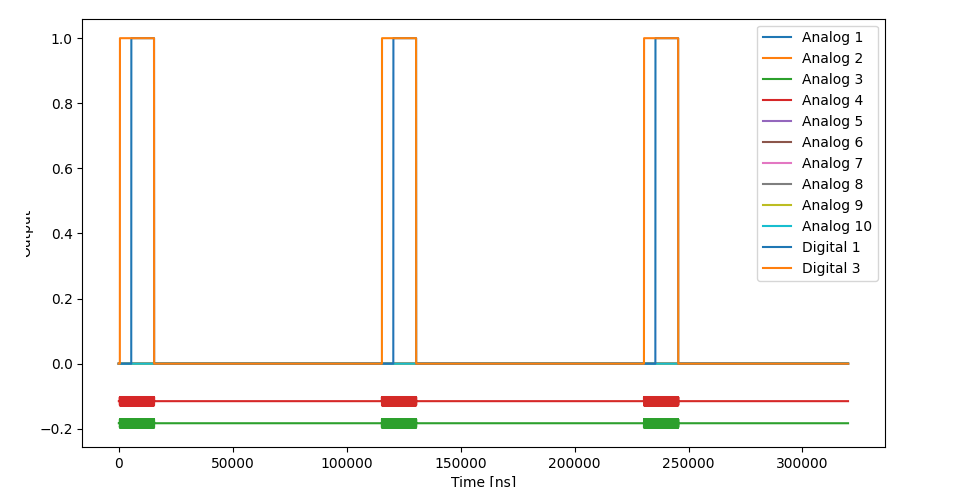

In [10]:
%matplotlib qt

#Sets the pulse length and the pulse amplitude at the resonator 
pulse_len=100_000
config,qm=update_readout_lenght(pulse_len,config,qmm)

pulse_amp=0.125
config,qm=update_pulse_amplitude(pulse_amp,config,qmm) 

twoPhoton_len=100_000
config,qm=update_two_photon_lenght(twoPhoton_len,config,qmm)

Readout_Delay = 5000 //4 # Delay before the first readout in ns (convert from clockcycle)

IF_pump=99.5e6 # defines the IF of the pump 

amp_factor=1 #Amplitude factor of the pump 

n_avg = 100  # Number of averaging loops

cooldown_time = 100_000 // 4 #cooldown time between the averages

offset_1=0.0180632734375
offset_2=0.015605841992187498
config,qm=update_offset(offset_1, offset_2,config,qmm)


with program() as raw_trace_prog:
    
    n = declare(int)
    adc_st = declare_stream(adc_trace=True)
    
    update_frequency("fluxline",IF_pump)

    with for_(n, 0, n < n_avg, n + 1):
        
        play("pumping"*amp(amp_factor), 'fluxline')
        
        #Delay time before the first readout 
        wait(Readout_Delay,"resonator")
        measure("fake_readout", "resonator", adc_st)
        
        wait(cooldown_time, "resonator") #Maybe need to cooldown both resonator and fluxline

    with stream_processing():
        
        # Will save average:
        adc_st.input1().average().save("adc1")
        adc_st.input2().average().save("adc2")
        
        # Will save only last run:
        adc_st.input1().save("adc1_single_run")
        adc_st.input2().save("adc2_single_run")

        
simulation = False
if simulation:
    
    simulation_config = SimulationConfig(
        duration=80000, simulation_interface=LoopbackInterface([("con1", 3, "con1", 1)])
    )
    job = qmm.simulate(config, raw_trace_prog, simulation_config)
    job.get_simulated_samples().con1.plot()
    
else: 
    #Execute the program     
    qm = qmm.open_qm(config)
    job = qm.execute(raw_trace_prog)

    results = fetching_tool(job, data_list=["adc1", "adc2", "adc1_single_run","adc2_single_run"], mode="wait_for_all")

    adc1, adc2, adc1_single_run, adc2_single_run = results.fetch_all()

    adc1 = u.raw2volts(adc1)
    adc2 = u.raw2volts(adc2)
    adc1_single_run = u.raw2volts(adc1_single_run)
    adc2_single_run = u.raw2volts(adc2_single_run)

    #Plotting 
    plt.figure()
    plt.subplot(121)
    plt.title("Single run")
    plt.plot(adc1_single_run, label="Input 1")
    plt.plot(adc2_single_run, label="Input 2")
    plt.xlabel("Time [ns]")
    plt.ylabel("Signal amplitude [V]")
    plt.legend()

    plt.subplot(122)
    plt.title("Averaged run")
    plt.plot(adc1, label="Input 1")
    plt.plot(adc2, label="Input 2")
    plt.xlabel("Time [ns]")
    plt.legend()
    plt.tight_layout()

    print("The mean offset of port 1 is: {}".format(np.mean(adc1)))
    print("The mean offset of port 2 is: {}".format(np.mean(adc2)))

2023-05-10 10:55:54,580 - qm - INFO - Flags: 
2023-05-10 10:55:54,581 - qm - INFO - Sending program to QOP
2023-05-10 10:55:55,061 - qm - INFO - Executing program
The mean offset of port 1 is: 1.41489013671875e-05
The mean offset of port 2 is: 2.4038671874999998e-05


# Single frequency IQ blob

Runs the IQ blob program for a single pump frequency that can be dfined with IF pump. The demodulation frequency is automatically taken as half of the total pump frequency

Need to make sure that the new updated IF frequency doesn't go over 350 MHz. 

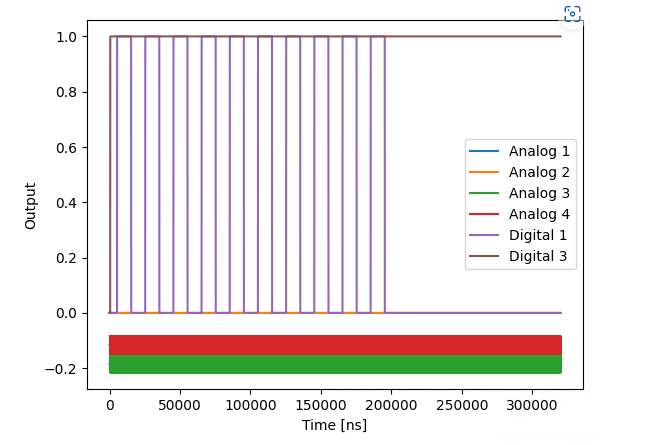

In [23]:
%matplotlib qt 
freqs_dict={}

#Update the readout pulse 
Readout_Len= 50_000     #length of the readout pulse in ns 
config,qm=update_readout_lenght(Readout_Len,config,qmm)


amp_factor_array=np.array([1.35]) #Prefactor of the amplitude 
amp_factor=amp_factor_array[0]

n_runs = 500000 #Number of readout to do 


freqs_dict[amp_factor]=np.array([ 99.2e6]) # 
IF_pump=freqs_dict[amp_factor][0]

IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 


Readout_Delay = 5000 //4 # Delay before the first readout in ns (convert from clockcycle)


Offset_IF=0  

points_delay=2142073 #Delay between readouts 


Expected_time=n_runs *(Readout_Len+points_delay*4)/60
print("Expected time {}".format(Expected_time*1e-9))

Expected time 71.8191


In [24]:
%%time 
time,I,Q=single_IQ_trace(IF_pump,IF_resonator,Offset_IF,amp_factor,n_runs,Readout_Delay,points_delay,Readout_Len,qm)

Data={}
Data[amp_factor]={}
Data[amp_factor][IF_pump]={}
Data[amp_factor][IF_pump]["I"]=I
Data[amp_factor][IF_pump]["Q"]=Q
Data[amp_factor][IF_pump]["time"]=time




2023-05-13 18:14:28,619 - qm - INFO - Flags: 
2023-05-13 18:14:28,620 - qm - INFO - Sending program to QOP
2023-05-13 18:14:29,091 - qm - INFO - Executing program


## Plotting single frequency 

Average signal : 0.001511238200521033


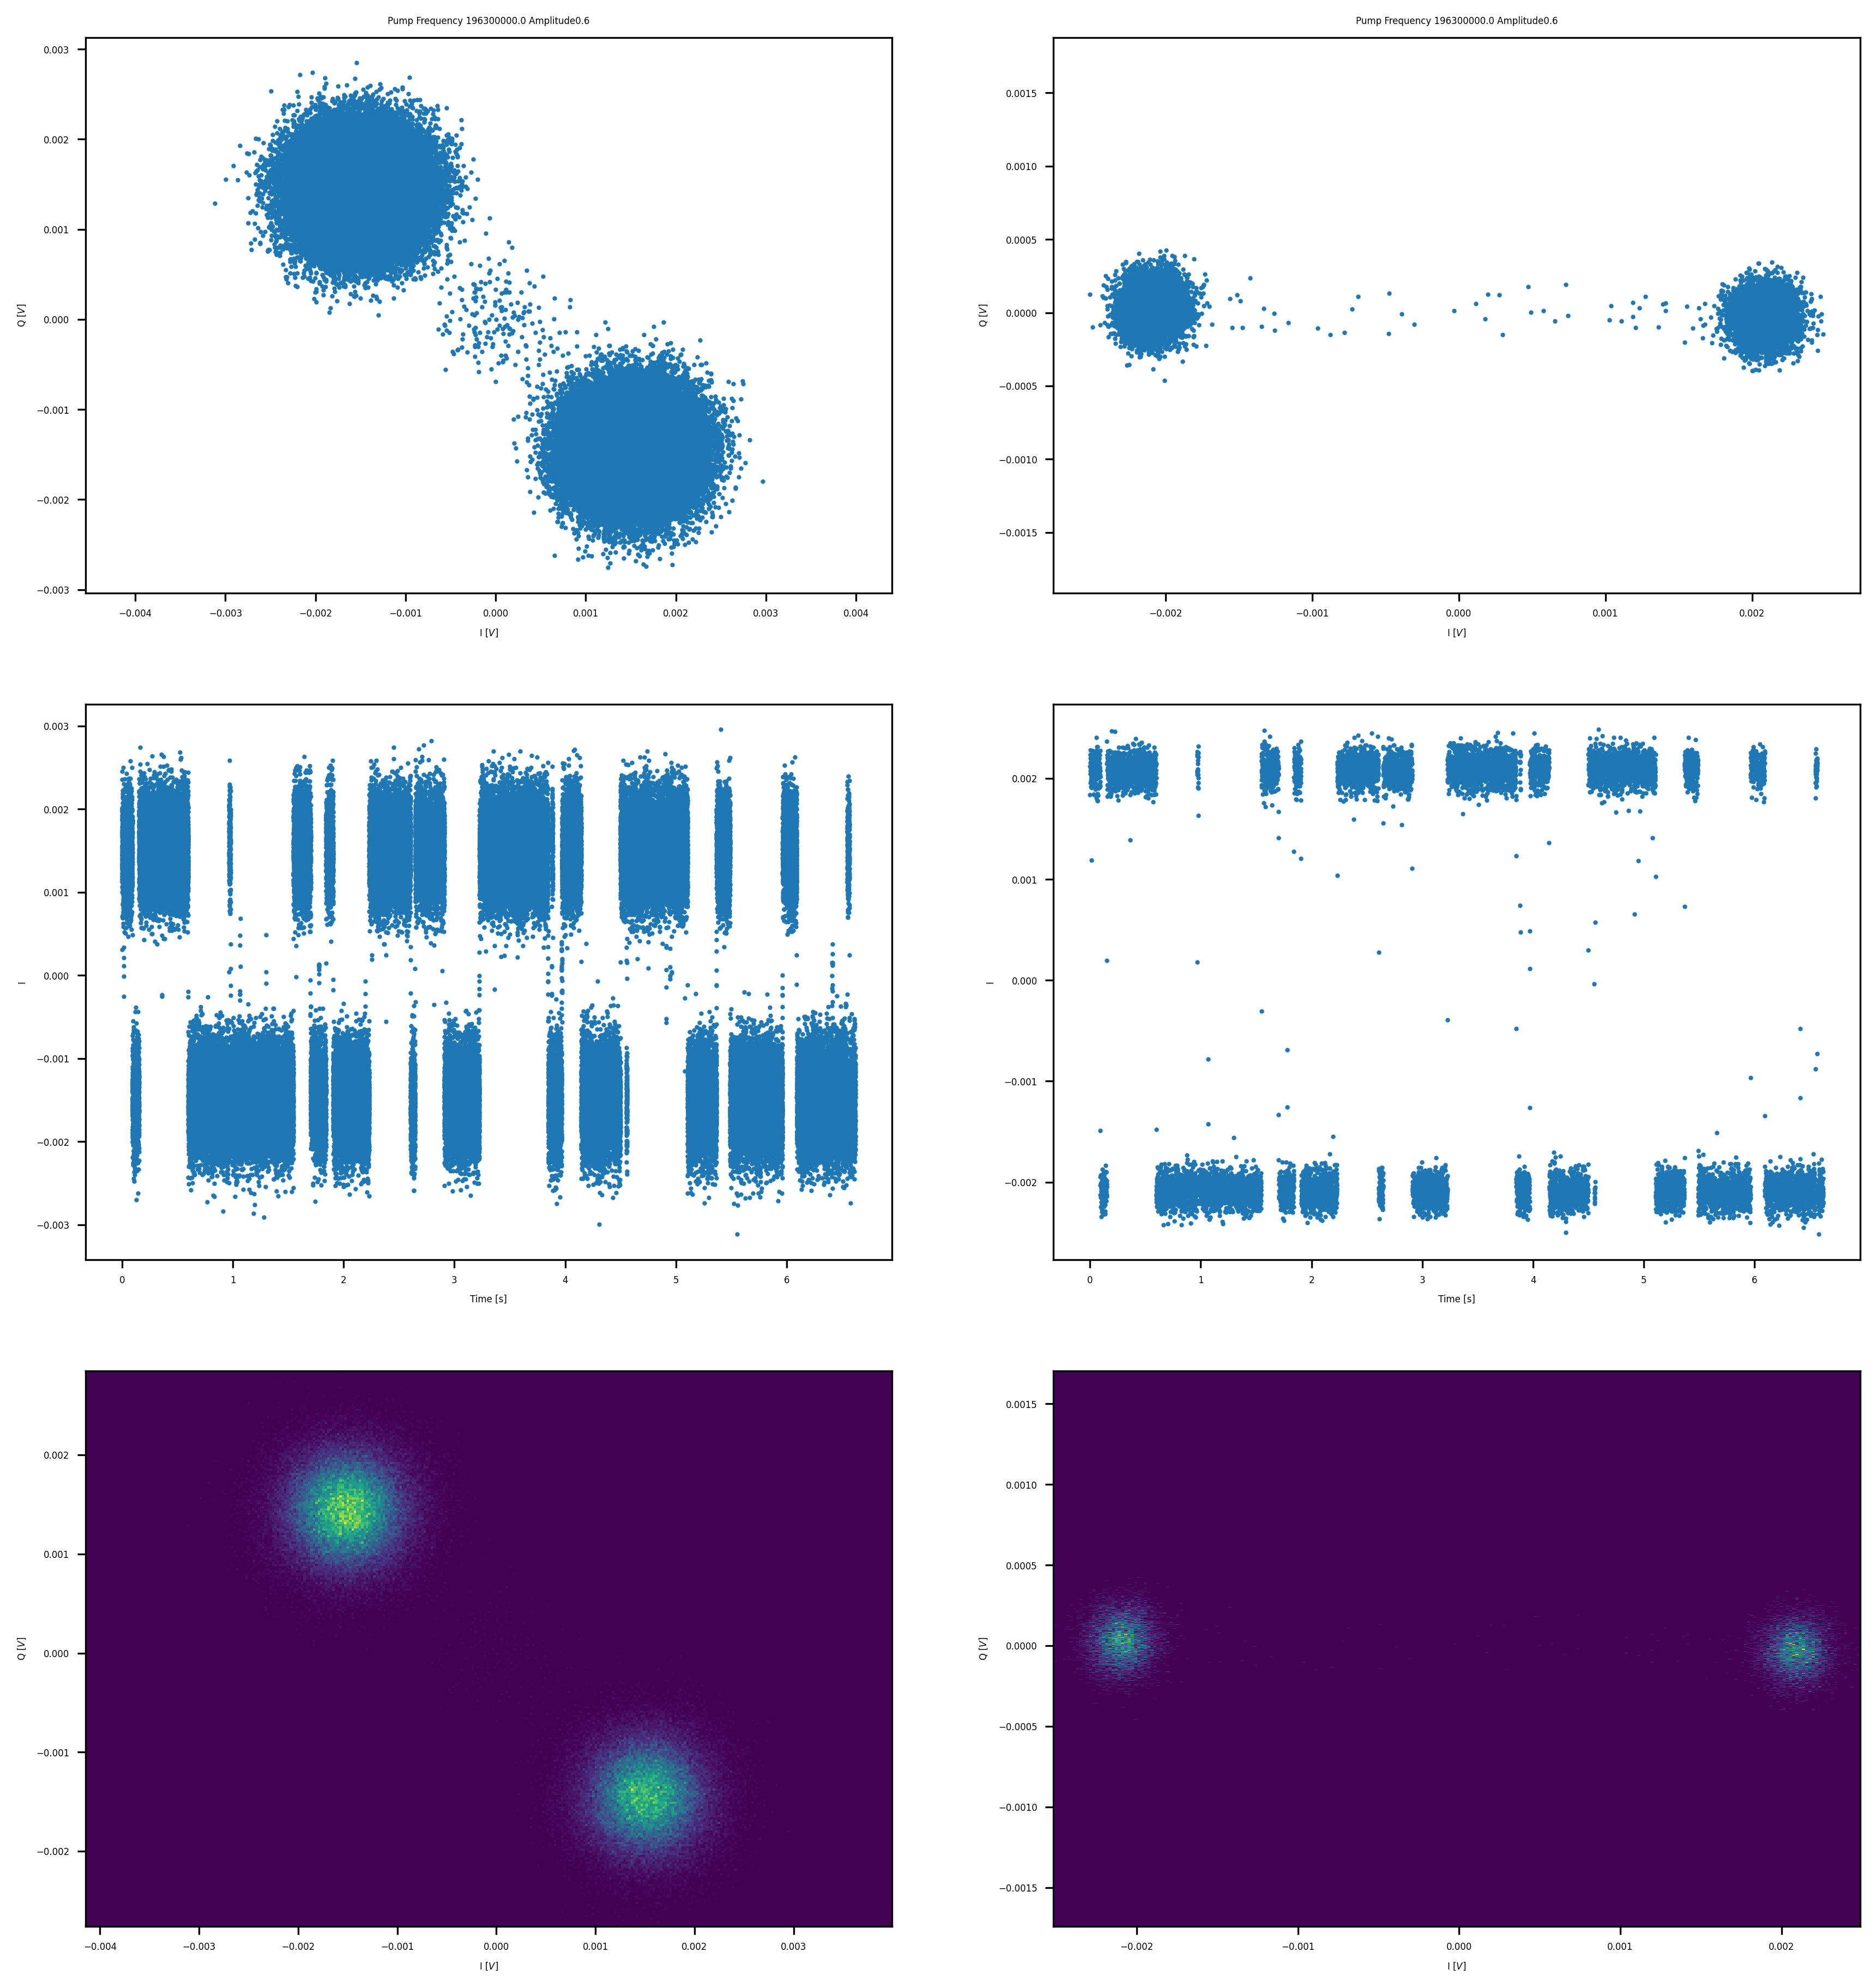

In [27]:
#Plotting with and without the noise reduction, would be better to get a single plotting function 

%matplotlib inline

n_bin=250 #bin size for the histogram 
figsize=(14,15)
fontsize=4
n_angle=100 #number of angles for the rotation 
n_avg=10 #number of average
dpi=300

plot_init_av_single(I,Q,time*1e-9,n_avg,n_bin,n_angle,figsize,fontsize,dpi)

Execution stopped by user!
0


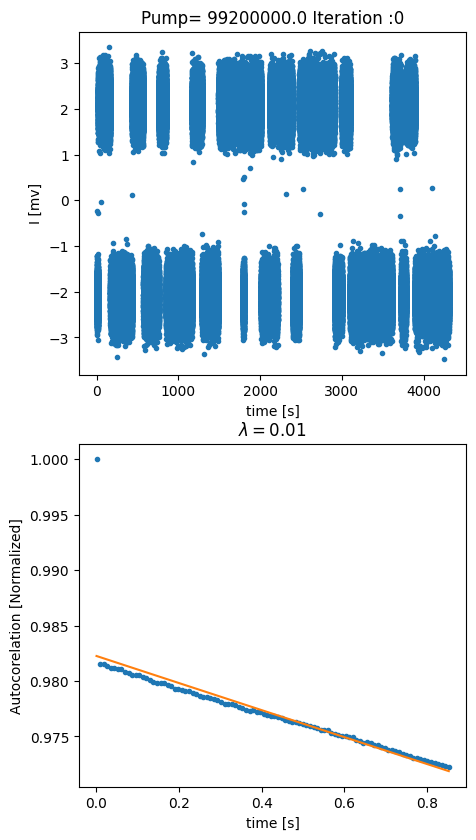

In [26]:
%matplotlib inline

nb_angle=150
n_avg=1
corr_length=100

Processed_Data=an.Extract_second_order_gap(Data,amp_factor_array,freqs_dict,nb_angle,n_avg,corr_length)
amp_factor=amp_factor_array[0]
freqs=freqs_dict[amp_factor]

for idx in range(len(freqs)):
    
    if Processed_Data[amp_factor][freqs[idx]]["fit"]:

        gap=Processed_Data[amp_factor][freqs[idx]]["gap"]
        coeff=Processed_Data[amp_factor][freqs[idx]]["fit_coeff"]
        time=Processed_Data[amp_factor][freqs[idx]]["time"]
        I=Processed_Data[amp_factor][freqs[idx]]["I"]
        y_fitted=Processed_Data[amp_factor][freqs[idx]]["y_fitted"]
        corr_list=Processed_Data[amp_factor][freqs[idx]]["corr_list"]

        fontsize=8
        fig, axs = plt.subplots( nrows=2, ncols=1, figsize=(5,10),dpi=100)
        ax=axs[1]
        ax.set_title("$\lambda= $"+str(round(gap,2)))
        ax.plot(time[0:corr_length],corr_list[0:corr_length],".")
        ax.plot(time[0:corr_length],y_fitted)
        ax.set_xlabel("time [s]")
        ax.set_ylabel("Autocorelation [Normalized]")
        
        ax=axs[0]
        ax.set_title("Pump= "+str(freqs[idx]) +" Iteration :" +str(idx))
        ax.plot(time,I*1e3,".")
        ax.set_xlabel("time [s]")
        ax.set_ylabel("I [mv]")


    else:
        print("No fit")
        time=Processed_Data[amp_factor][freqs[idx]]["time"]
        corr_list=Processed_Data[amp_factor][freqs[idx]]["corr_list"]
        
        
        
        fontsize=8
        fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5,5),dpi=100)
        ax=axs
        ax.set_title("Pump= "+str(freqs[idx]) +" Iteration :" +str(idx) + " No fit")
        ax.plot(time[0:corr_length],corr_list[0:corr_length])
        ax.set_xlabel("time [s]")
        ax.set_ylabel("Autocorelation [Normalized]")

## Saving for single frequency 

In [25]:
#Saving the data
cooldown_date=Cooldown_Date #top folder   
device="second_order" #second folder 
name="measurement_freq" # third folder 
meastype="1p35_992_50jumps" #Final file name 

datadict={}

datadict={}
datadict["freqs_dict"]=freqs_dict
datadict["Readout_Len"]=Readout_Len
datadict["Readout_Delay"]=Readout_Delay*4
datadict["octave_output_gain"]=octave_output_gain
datadict["amp_factor_array"]=amp_factor_array 
datadict["points_delay"]=points_delay
datadict["Data"]=Data
datadict["config"]=config

#Configuration file copy 
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_readout"]=IF_resonator
datadict["LO_readout"]=LO_readout

an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)

saving


In [ ]:
#loading the data 
filepath=r"\\sb1files\HQC\Users\beaulieu\Data\Run01\104\2023_04_14\excit_to_vac\Single_freq\test.npz"

npzfile=np.load(filepath,allow_pickle=True)
npzfile["multidata"][()]
freqs_array=npzfile["multidata"][()]["freqs_array"]
Data=npzfile["multidata"][()]["Data"]
amp_factor_array=npzfile["multidata"][()]["amp_factor_array"]
Pump_Delay=npzfile["multidata"][()]["Pump_Delay"]

# Multiple frequencies of single measurement with dual demodualtion 

In [18]:
IF_pump=99.9e6  #where we go  
IF_left=98.9e6   # whre we start
pump_step=0.02e6

np.arange(IF_left,IF_pump,pump_step)

array([98900000., 98920000., 98940000., 98960000., 98980000., 99000000.,
       99020000., 99040000., 99060000., 99080000., 99100000., 99120000.,
       99140000., 99160000., 99180000., 99200000., 99220000., 99240000.,
       99260000., 99280000., 99300000., 99320000., 99340000., 99360000.,
       99380000., 99400000., 99420000., 99440000., 99460000., 99480000.,
       99500000., 99520000., 99540000., 99560000., 99580000., 99600000.,
       99620000., 99640000., 99660000., 99680000., 99700000., 99720000.,
       99740000., 99760000., 99780000., 99800000., 99820000., 99840000.,
       99860000., 99880000.])

In [50]:
#Select the frequencies 
freqs_dict={}

amp_factor_array=np.array([1.05]) #Prefactor of the amplitude 
amp_factor=amp_factor_array[0]

span=1.3 * u.MHz # Span of the pumping 
df = 0.5* u.MHz # Step of the pumping 0.01
IF_center=0.1954e9 

freqs=np.arange(IF_center-span/2, IF_center+span/2, df)


fmin= 99.1e6
fmax=99.7e6
df=0.02* u.MHz
freqs=np.arange(fmin, fmax+df/2, df)

freqs_dict[amp_factor]=freqs

freqs

array([99100000., 99120000., 99140000., 99160000., 99180000., 99200000.,
       99220000., 99240000., 99260000., 99280000., 99300000., 99320000.,
       99340000., 99360000., 99380000., 99400000., 99420000., 99440000.,
       99460000., 99480000., 99500000., 99520000., 99540000., 99560000.,
       99580000., 99600000., 99620000., 99640000., 99660000., 99680000.,
       99700000.])

In [51]:
%matplotlib qt 

#Update the readout pulse 
Readout_Len= 50_000     #6_557_763 #length of the readout pulse in ns 
config,qm=update_readout_lenght(Readout_Len,config,qmm)

n_runs = 500_000 #Number of readout to do 

Readout_Delay = 5000 //4 # Delay before the first readout in ns (convert from clockcycle)

Offset_IF=0  #

points_delay=16//4 #Delay between readouts 


save_Data=False
#Saving the data
cooldown_date=Cooldown_Date #top folder 
device="second_order_jumps" #second folder 
name="Multiple_freq" # third folder 
meastype="0p6_amp_test" #Final file name 


print("The different frequency {}".format(freqs))
Expected_time=((Readout_Len+points_delay*4)*n_runs*len(freqs))*1e-9/60
print("The expected time : {} min".format(Expected_time))

The different frequency [99100000. 99120000. 99140000. 99160000. 99180000. 99200000. 99220000.
 99240000. 99260000. 99280000. 99300000. 99320000. 99340000. 99360000.
 99380000. 99400000. 99420000. 99440000. 99460000. 99480000. 99500000.
 99520000. 99540000. 99560000. 99580000. 99600000. 99620000. 99640000.
 99660000. 99680000. 99700000.]
The expected time : 12.920800000000002 min


In [52]:
%%time

Data={} #dictionnary to hold all the data 
Data[amp_factor]={}
freqs=freqs_dict[amp_factor]

for idx,IF_pump in enumerate(freqs) :
    
    print("########################### Frequency "+str(IF_pump+LO_fluxline)+"########################### "+str(idx/len(freqs)))

    IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 
    
    time,I,Q=single_IQ_trace(IF_pump,IF_resonator,Offset_IF,amp_factor,n_runs,Readout_Delay,points_delay,Readout_Len,qm)
    
    plt.close()
    
    Data[amp_factor][IF_pump]={}
    Data[amp_factor][IF_pump]["I"]=I
    Data[amp_factor][IF_pump]["Q"]=Q
    Data[amp_factor][IF_pump]["time"]=time
    
    
if save_Data:
    
    datadict={}
    datadict["freqs_dict"]=freqs_dict
    datadict["Readout_Len"]=Readout_Len
    datadict["Readout_Delay"]=Readout_Delay*4
    datadict["octave_output_gain"]=octave_output_gain
    datadict["amp_factor_array"]=amp_factor_array
    datadict["config"]["points_delay"]=points_delay
    datadict["Data"]=Data
    datadict["config"]=config

    #Configuration file copy 
    datadict["LO_fluxline"]=LO_fluxline
    datadict["IF_readout"]=IF_resonator
    datadict["LO_readout"]=LO_readout
    
    an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)

########################### Frequency 8699100000.0########################### 0.0
2023-05-10 12:24:53,747 - qm - INFO - Flags: 
2023-05-10 12:24:53,748 - qm - INFO - Sending program to QOP
2023-05-10 12:24:54,619 - qm - INFO - Executing program
Execution stopped by user!
########################### Frequency 8699120000.0########################### 0.03225806451612903
2023-05-10 12:25:20,944 - qm - INFO - Flags: 
2023-05-10 12:25:20,945 - qm - INFO - Sending program to QOP
2023-05-10 12:25:21,775 - qm - INFO - Executing program
Execution stopped by user!
########################### Frequency 8699140000.0########################### 0.06451612903225806
2023-05-10 12:25:48,312 - qm - INFO - Flags: 
2023-05-10 12:25:48,312 - qm - INFO - Sending program to QOP
2023-05-10 12:25:48,783 - qm - INFO - Executing program
Execution stopped by user!
########################### Frequency 8699160000.0########################### 0.0967741935483871
2023-05-10 12:26:15,315 - qm - INFO - Flags: 
2023-05-1

## Saving 

In [55]:
#Saving the data 
cooldown_date=Cooldown_Date #top folder 
device="second_order" #second folder 
name="Multiple_freq" # third folder 
meastype="test_1_1p05" #Final file name 

datadict={}

datadict["freqs_dict"]=freqs_dict
datadict["Readout_Len"]=Readout_Len
datadict["Readout_Delay"]=Readout_Delay*4
datadict["octave_output_gain"]=octave_output_gain
datadict["amp_factor_array"]=amp_factor_array
datadict["points_delay"]=points_delay
datadict["Data"]=Data
datadict["config"]=config

#Configuration file copy 
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_readout"]=IF_resonator
datadict["LO_readout"]=LO_readout

an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)

saving


In [ ]:
#Loading the data 

filepath= r"\\sb1files\HQC\Users\beaulieu\Data\Run01\104\2023_04_14\excit_to_vac\Multiple_freq\0p3_amp_test.npz"

npzfile=np.load(filepath,allow_pickle=True)
#npzfile["multidata"][()]

Pump_Delay=npzfile["multidata"][()]["Pump_Delay"]
Data=npzfile["multidata"][()]["Data"]
freqs_array=npzfile["multidata"][()]["freqs_array"]
amp_factor_array=npzfile["multidata"][()]["amp_factor_array"]
amp_factor_array_high=npzfile["multidata"][()]["amp_factor_array_high"]

## Plotting for multiple frequencies 

In [26]:
%matplotlib qt 

n_bin=250 #bin size for the histogram 
figsize=(14,15)
fontsize=4
n_angle=100 #number of angles for the rotation 
n_avg=10 #number of average
dpi=300


amp_factor=amp_factor_array[0]
freqs=freqs_dict[amp_factor]

for idx in range(len(freqs)):
    
    IF_pump=freqs[idx]
    I=Data[amp_factor][freqs[idx]]["I"]
    Q=Data[amp_factor][freqs[idx]]["Q"]
    time=Data[amp_factor][freqs[idx]]["time"]

    plot_init_av_single(I,Q,time*1e-9,n_avg,n_bin,n_angle,figsize,fontsize,dpi)

Average signal : 0.00022891141553649903
Average signal : 0.0002349120020141602
Average signal : 0.00024078570512390133
Average signal : 0.00031765799408264156
Average signal : 0.0004720842993927002
Average signal : 0.0006483534495819092
Average signal : 0.000753789492880249
Average signal : 0.0007468909906066895
Average signal : 0.000708286908743286
Average signal : 0.0006666197752746582
Average signal : 0.0006248511926849365
Average signal : 0.0005767620405700683
Average signal : 0.0005376562915740968
Average signal : 0.0004955900741912843
Average signal : 0.0004557989657470702
Average signal : 0.0004173653484191894
Average signal : 0.0003807876729278565
Average signal : 0.00035071893717346185
Average signal : 0.0003203655524108887
Average signal : 0.00029207952456359866
Average signal : 0.00026865607206420897
Average signal : 0.00025203321575012206
Average signal : 0.00023797942839050293
Average signal : 0.00023374765344543459
Average signal : 0.000227434392980957
Average signal : 0.

In [27]:
plt.close("all")

In [53]:
%matplotlib qt
nb_angle=150
n_avg=10
corr_length=500

Processed_Data=an.Extract_second_order_gap(Data,amp_factor_array,freqs_dict,nb_angle,n_avg,corr_length)
amp_factor=amp_factor_array[0]
freqs=freqs_dict[amp_factor]

for idx in range(len(freqs)):
    
    if Processed_Data[amp_factor][freqs[idx]]["fit"]:

        gap=Processed_Data[amp_factor][freqs[idx]]["gap"]
        coeff=Processed_Data[amp_factor][freqs[idx]]["fit_coeff"]
        time=Processed_Data[amp_factor][freqs[idx]]["time"]
        I=Processed_Data[amp_factor][freqs[idx]]["I"]
        y_fitted=Processed_Data[amp_factor][freqs[idx]]["y_fitted"]
        corr_list=Processed_Data[amp_factor][freqs[idx]]["corr_list"]

        fontsize=8
        fig, axs = plt.subplots( nrows=2, ncols=1, figsize=(5,10),dpi=100)
        ax=axs[1]
        ax.set_title("$\lambda= $"+str(round(gap,2)))
        ax.plot(time[0:corr_length],corr_list[0:corr_length],".")
        ax.plot(time[0:corr_length],y_fitted)
        ax.set_xlabel("time [s]")
        ax.set_ylabel("Autocorelation [Normalized]")
        
        ax=axs[0]
        ax.set_title("Pump= "+str(freqs[idx]) +" Iteration :" +str(idx))
        ax.plot(time,I*1e3,".")
        ax.set_xlabel("time [s]")
        ax.set_ylabel("I [mv]")


    else:
        print("No fit")
        time=Processed_Data[amp_factor][freqs[idx]]["time"]
        corr_list=Processed_Data[amp_factor][freqs[idx]]["corr_list"]
        
        
        
        fontsize=8
        fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5,5),dpi=100)
        ax=axs
        ax.set_title("Pump= "+str(freqs[idx]) +" Iteration :" +str(idx) + " No fit")
        ax.plot(time[0:corr_length],corr_list[0:corr_length])
        ax.set_xlabel("time [s]")
        ax.set_ylabel("Autocorelation [Normalized]")

0
No fit
No fit


## Extracting the Liouvillian gap 

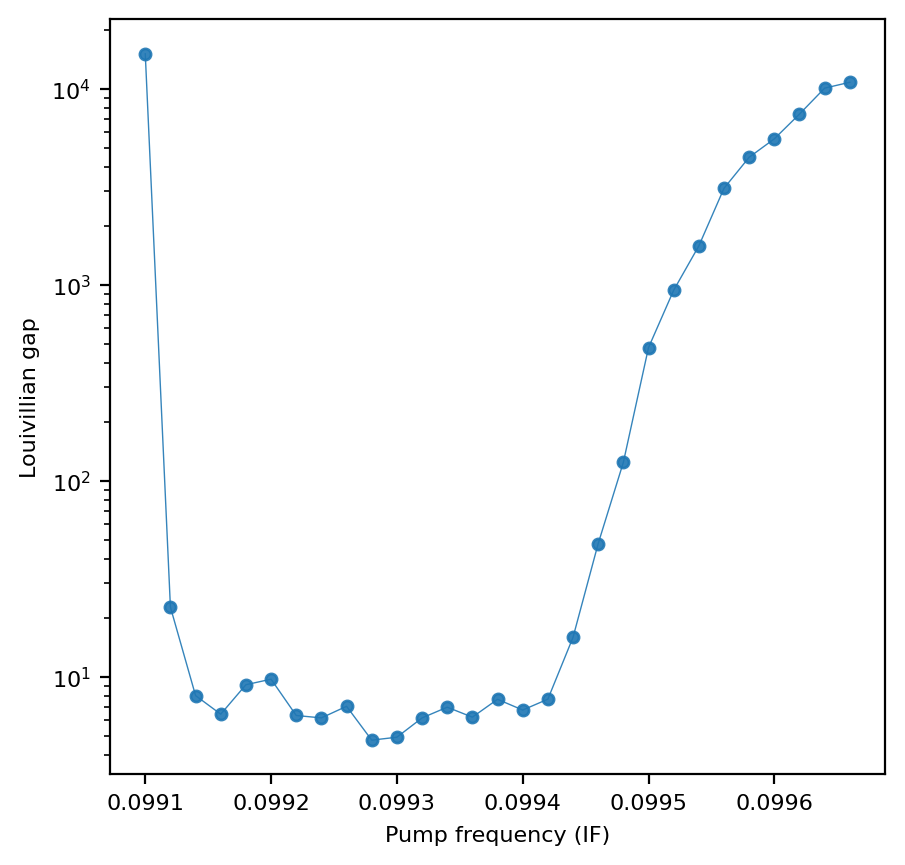

In [54]:
%matplotlib inline

amp_factor=amp_factor_array[0]
freqs=freqs_dict[amp_factor]

gap_array=[]
freq_gap_array=[]

for idx in range(len(freqs)):
    
    if Processed_Data[amp_factor][freqs[idx]]["fit"]:
        gap_array.append(Processed_Data[amp_factor][freqs[idx]]["gap"])
        freq_gap_array.append(freqs[idx])
        
gap_array=np.array(gap_array)
freq_gap_array=np.array(freq_gap_array)
        
        

# figsize=(5,4)

fontsize=8
figsize=(5,4)
fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5,5),dpi=200)

axs.plot(freq_gap_array/1e9,gap_array,'.-',alpha=.9, lw=.5, ms=8)
axs.set_xlabel("Pump frequency (IF)",fontsize=fontsize)
axs.set_ylabel("Louivillian gap",fontsize=fontsize)
axs.tick_params(axis='x', labelsize=fontsize)
axs.tick_params(axis='y', labelsize=fontsize)
axs.set_yscale('log')

# Multiple amplitudes 

In [98]:
#Select the frequencies & amplitudes factors 

#Sets of amplitude factors 
amp_factor_array=np.array([0.4,0.5, 0.6,0.7]) 

fmin= 196.1e6
fmax=196.6e6
df=0.025* u.MHz
freqs_array_1=np.arange(fmin, fmax+df/2, df)

fmin= 196.1e6
fmax=196.6e6
df=0.025* u.MHz
freqs_array_2=np.arange(fmin, fmax+df/2, df)

freqs_dict={}
freqs_dict[0.5]=freqs_array_1
freqs_dict[0.6]=freqs_array_2
freqs_dict[0.4]=freqs_array_2
freqs_dict[0.7]=freqs_array_2

#calculate the total number of frequencies 
number_frequencies=0
for i in range(len(amp_factor_array)):
    number_frequencies+=len(freqs_dict[amp_factor_array[i]])



freqs_dict

{0.5: array([1.96100e+08, 1.96125e+08, 1.96150e+08, 1.96175e+08, 1.96200e+08,
        1.96225e+08, 1.96250e+08, 1.96275e+08, 1.96300e+08, 1.96325e+08,
        1.96350e+08, 1.96375e+08, 1.96400e+08, 1.96425e+08, 1.96450e+08,
        1.96475e+08, 1.96500e+08, 1.96525e+08, 1.96550e+08, 1.96575e+08,
        1.96600e+08]),
 0.6: array([1.96100e+08, 1.96125e+08, 1.96150e+08, 1.96175e+08, 1.96200e+08,
        1.96225e+08, 1.96250e+08, 1.96275e+08, 1.96300e+08, 1.96325e+08,
        1.96350e+08, 1.96375e+08, 1.96400e+08, 1.96425e+08, 1.96450e+08,
        1.96475e+08, 1.96500e+08, 1.96525e+08, 1.96550e+08, 1.96575e+08,
        1.96600e+08]),
 0.4: array([1.96100e+08, 1.96125e+08, 1.96150e+08, 1.96175e+08, 1.96200e+08,
        1.96225e+08, 1.96250e+08, 1.96275e+08, 1.96300e+08, 1.96325e+08,
        1.96350e+08, 1.96375e+08, 1.96400e+08, 1.96425e+08, 1.96450e+08,
        1.96475e+08, 1.96500e+08, 1.96525e+08, 1.96550e+08, 1.96575e+08,
        1.96600e+08]),
 0.7: array([1.96100e+08, 1.96125e+08, 1

In [100]:
%matplotlib qt
#Update the readout pulse 
Readout_Len= 50_000     #6_557_763 #length of the readout pulse in ns 
config,qm=update_readout_lenght(Readout_Len,config,qmm)

n_runs = 500_000 #Number of readout to do 

Readout_Delay = 5000 //4 # Delay before the first readout in ns (convert from clockcycle)

Offset_IF=0  #

points_delay=16//4 #Delay between readouts 


save_Data=False
#Saving the data
cooldown_date=Cooldown_Date #top folder 
device="second_order_jumps" #second folder 
name="Multiple_amplitude" # third folder 
meastype="0p6_amp_test" #Final file name 


print("The different frequency {}".format(freqs_dict))
Expected_time=((Readout_Len+points_delay*4)*n_runs*number_frequencies)*1e-9/60
print("The expected time : {} min".format(Expected_time))

The different frequency {0.5: array([1.96100e+08, 1.96125e+08, 1.96150e+08, 1.96175e+08, 1.96200e+08,
       1.96225e+08, 1.96250e+08, 1.96275e+08, 1.96300e+08, 1.96325e+08,
       1.96350e+08, 1.96375e+08, 1.96400e+08, 1.96425e+08, 1.96450e+08,
       1.96475e+08, 1.96500e+08, 1.96525e+08, 1.96550e+08, 1.96575e+08,
       1.96600e+08]), 0.6: array([1.96100e+08, 1.96125e+08, 1.96150e+08, 1.96175e+08, 1.96200e+08,
       1.96225e+08, 1.96250e+08, 1.96275e+08, 1.96300e+08, 1.96325e+08,
       1.96350e+08, 1.96375e+08, 1.96400e+08, 1.96425e+08, 1.96450e+08,
       1.96475e+08, 1.96500e+08, 1.96525e+08, 1.96550e+08, 1.96575e+08,
       1.96600e+08]), 0.4: array([1.96100e+08, 1.96125e+08, 1.96150e+08, 1.96175e+08, 1.96200e+08,
       1.96225e+08, 1.96250e+08, 1.96275e+08, 1.96300e+08, 1.96325e+08,
       1.96350e+08, 1.96375e+08, 1.96400e+08, 1.96425e+08, 1.96450e+08,
       1.96475e+08, 1.96500e+08, 1.96525e+08, 1.96550e+08, 1.96575e+08,
       1.96600e+08]), 0.7: array([1.96100e+08, 1.961

In [101]:
%%time
Data={} #dictionnary to hold all the data 

for i in range(len(amp_factor_array)):

    amp_factor=amp_factor_array[i]
    freqs=freqs_dict[amp_factor] 
    
    print("####################################### Amplitude "+str(amp_factor)+"######################################## ")
   
    Data[amp_factor]={}
          
    for idx,IF_pump in enumerate(freqs):

        print("########################### Frequency "+str(IF_pump+LO_fluxline)+"########################### "+str(idx/len(freqs)))

        IF_resonator=(LO_fluxline+IF_pump)/2-LO_readout #demodulate at half of the pump IF by default 

        time,I,Q=single_IQ_trace(IF_pump,IF_resonator,Offset_IF,amp_factor,n_runs,Readout_Delay,points_delay,Readout_Len,qm)
        plt.close()
        
        Data[amp_factor][IF_pump]={}
        Data[amp_factor][IF_pump]["time"]=time
        Data[amp_factor][IF_pump]["I"]=I
        Data[amp_factor][IF_pump]["Q"]=Q
    
    
if save_Data:
    
    datadict={}
    datadict["freqs_dict"]=freqs_dict
    datadict["Readout_Len"]=Readout_Len
    datadict["Readout_Delay"]=Readout_Delay*4
    datadict["octave_output_gain"]=octave_output_gain
    datadict["amp_factor_array"]=amp_factor_array
    datadict["config"]["points_delay"]=points_delay
    datadict["Data"]=Data
    datadict["config"]=config

    #Configuration file copy 
    datadict["LO_fluxline"]=LO_fluxline
    datadict["IF_readout"]=IF_resonator
    datadict["LO_readout"]=LO_readout
    
    
    an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)

####################################### Amplitude 0.4######################################## 
########################### Frequency 8696100000.0########################### 0.0
2023-05-01 11:35:24,045 - qm - INFO - Flags: 
2023-05-01 11:35:24,045 - qm - INFO - Sending program to QOP
2023-05-01 11:35:24,930 - qm - INFO - Executing program
Execution stopped by user!
########################### Frequency 8696125000.0########################### 0.047619047619047616
2023-05-01 11:35:51,355 - qm - INFO - Flags: 
2023-05-01 11:35:51,356 - qm - INFO - Sending program to QOP
2023-05-01 11:35:51,819 - qm - INFO - Executing program
Execution stopped by user!
########################### Frequency 8696150000.0########################### 0.09523809523809523
2023-05-01 11:36:19,020 - qm - INFO - Flags: 
2023-05-01 11:36:19,021 - qm - INFO - Sending program to QOP
2023-05-01 11:36:19,849 - qm - INFO - Executing program
Execution stopped by user!
########################### Frequency 8696175000.0######

## Saving 

In [108]:
#Saving the data 
cooldown_date=Cooldown_Date #top folder 
device="second_order" #second folder 
name="Multiple_amp" # third folder 
meastype="small_map_test" #Final file name 

datadict={}

datadict["freqs_dict"]=freqs_dict
datadict["Readout_Len"]=Readout_Len
datadict["Readout_Delay"]=Readout_Delay*4
datadict["octave_output_gain"]=octave_output_gain
datadict["amp_factor_array"]=amp_factor_array
datadict["points_delay"]=points_delay
datadict["Data"]=Data
datadict["config"]=config

#Configuration file copy 
datadict["LO_fluxline"]=LO_fluxline
datadict["IF_readout"]=IF_resonator
datadict["LO_readout"]=LO_readout

an.save_with_numpy(datadict, meastype, name, device, cooldown_date, filepath=Saving_Path)

saving in new directory


## Ploting for different frequencies 

In [102]:
%matplotlib qt
nb_angle=150
n_avg=10
corr_length=1000

Processed_Data=an.Extract_second_order_gap(Data,amp_factor_array,freqs_dict,nb_angle,n_avg,corr_length)


0
1
2
3
No fit
No fit


In [105]:
%matplotlib qt
idx=2
amp_factor=amp_factor_array[idx]
freqs=freqs_dict[amp_factor]

for idx in range(len(freqs)):
    
    if Processed_Data[amp_factor][freqs[idx]]["fit"]:

        gap=Processed_Data[amp_factor][freqs[idx]]["gap"]
        coeff=Processed_Data[amp_factor][freqs[idx]]["fit_coeff"]
        time=Processed_Data[amp_factor][freqs[idx]]["time"]
        I=Processed_Data[amp_factor][freqs[idx]]["I"]
        y_fitted=Processed_Data[amp_factor][freqs[idx]]["y_fitted"]
        corr_list=Processed_Data[amp_factor][freqs[idx]]["corr_list"]

        fontsize=8
        fig, axs = plt.subplots( nrows=2, ncols=1, figsize=(5,10),dpi=100)
        ax=axs[1]
        ax.set_title("$\lambda= $"+str(round(gap,2)))
        ax.plot(time[0:corr_length],corr_list[0:corr_length],".")
        ax.plot(time[0:corr_length],y_fitted)
        ax.set_xlabel("time [s]")
        ax.set_ylabel("Autocorelation [Normalized]")
        
        ax=axs[0]
        ax.set_title("Pump= "+str(freqs[idx]) +" Iteration :" +str(idx))
        ax.plot(time,I*1e3,".")
        ax.set_xlabel("time [s]")
        ax.set_ylabel("I [mv]")


    else:
        print("No fit")
        time=Processed_Data[amp_factor][freqs[idx]]["time"]
        corr_list=Processed_Data[amp_factor][freqs[idx]]["corr_list"]
        
        
        
        fontsize=8
        fig, axs = plt.subplots( nrows=1, ncols=1, figsize=(5,5),dpi=100)
        ax=axs
        ax.set_title("Pump= "+str(freqs[idx]) +" Iteration :" +str(idx) + " No fit")
        ax.plot(time[0:corr_length],corr_list[0:corr_length])
        ax.set_xlabel("time [s]")
        ax.set_ylabel("Autocorelation [Normalized]")

No fit


## Extracting the Liouivillian gap 

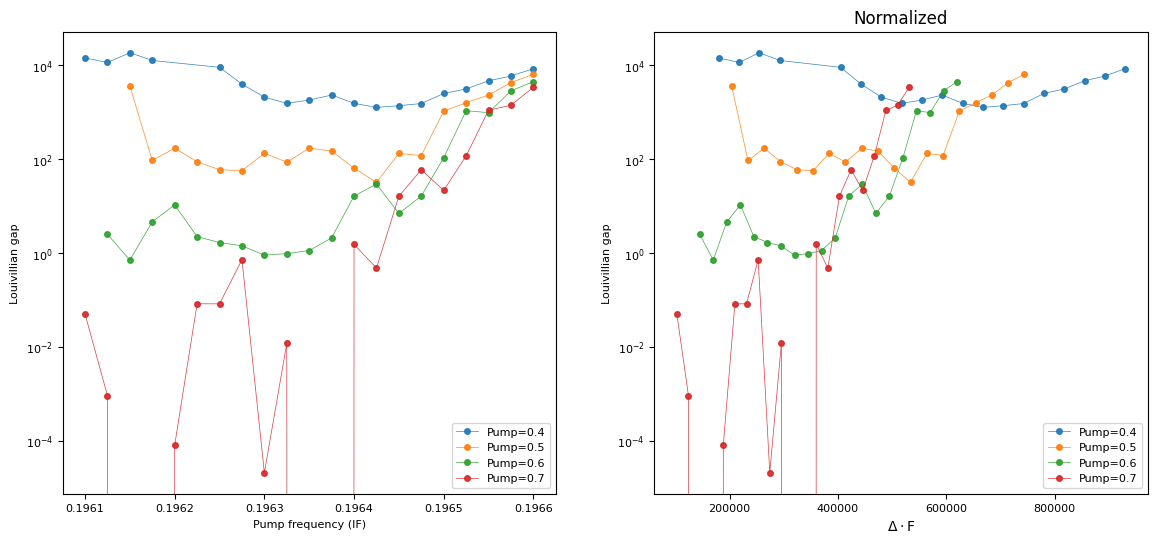

In [103]:
%matplotlib inline

center_freq=4.34799e9*2
Gi=0.6

fontsize=8
figsize=(5,4)
fig, axs = plt.subplots( ncols=2, figsize=(14,6))

for j in range(len(amp_factor_array)):
    
    amp_factor=amp_factor_array[j]
    freqs=freqs_dict[amp_factor]
    gap_array=[]
    freq_gap_array=[]
    
    for idx in range(len(freqs)):

        if Processed_Data[amp_factor][freqs[idx]]["fit"]:
            gap_array.append(Processed_Data[amp_factor][freqs[idx]]["gap"])
            freq_gap_array.append(freqs[idx])
        
    gap_array=np.array(gap_array)
    freq_gap_array=np.array(freq_gap_array)
    
    ax=axs[0]
    ax.plot(freq_gap_array/1e9,gap_array,".-",label=f'Pump={amp_factor:.1f}', alpha=.9, lw=.5, ms=8)    
    ax=axs[1]
    Gx=amp_factor
    ax.plot( ((freq_gap_array+LO_fluxline)-center_freq)*Gi/Gx,gap_array,".-",label=f'Pump={amp_factor:.1f}', alpha=.9, lw=.5, ms=8)
  
ax=axs[0]
ax.set_xlabel("Pump frequency (IF)",fontsize=fontsize)
ax.set_ylabel("Louivillian gap",fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)  
ax.legend(fontsize=fontsize)
ax.set_yscale('log')

ax=axs[1]
ax.set_title("Normalized")
ax.set_ylabel("Louivillian gap",fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize) 
ax.set_xlabel('$\Delta\cdot$F')
ax.legend(fontsize=fontsize)
ax.set_yscale('log')
